In [ ]:
# ..... integrate with STACAS ..... #

In [ ]:
library(Seurat)
library(STACAS)
library(dplyr)
library(ggplot2)

In [6]:
# get list of samples
stages = c(rep('stage23', 2), rep(c('stage28', 'stage32'), each = 3))
samples = c('sample3', 'sample10', 'sample5', 'sample10', 'sample11',
           'sample5', 'sample10', 'sample12')

In [7]:
# load cell type anno from MetaMarkers
# tab1 = read.delim('chicken_celltype_annotations.csv', sep = ',')
tab1 = read.delim('chicken_manual_anno1.csv', sep = ',')
tab1$consensus_type = tab1$anno1
tab1[1:2,]

stage           cluster anno1       anno2 confident consensus_type
1 stage23_sample3 0       endocardial       yes       endocardial   
2 stage23_sample3 1       erythroid         yes       erythroid

In [8]:
meta.batch <- "dataset"
meta.label <- "consensus_type"

In [9]:
# load data
mat1 = c()
mtd1 = c()
cols1 = c('species', 'dataset', 'consensus_type', 'old_clusters')

for(id3 in 1:length(samples)){
    sc3 = readRDS(paste0(stages[id3], '_', samples[id3], '_data.rds'))
    sc3$dataset = paste0(stages[id3], '_', samples[id3])
    sc3$species = 'chicken'
    sc3$old_clusters = sc3$seurat_clusters

    # add simple cell anno
    # sc3$consensus_type = tab1$consensus_type[match(rownames(sc3@meta.data), tab1$barcode)]
    tab2 = tab1[which(tab1$stage == paste0(stages[id3], '_', samples[id3])),]
    sc3$consensus_type = tab2$consensus_type[match(sc3$seurat_clusters, tab2$cluster)]
    
    mat1 = cbind(mat1, LayerData(sc3, assay = 'RNA', layer = 'counts'))
    mtd1 = rbind(mtd1, sc3@meta.data[,cols1])    
}

In [9]:
sce = CreateSeuratObject(counts = mat1, meta.data = mtd1)

obj.list <- SplitObject(sce, split.by = meta.batch)

In [10]:
for (i in 1:length(obj.list)) {
  obj.list[[i]] <- obj.list[[i]] |>
                  NormalizeData(assay = "RNA") |>
                  FindVariableFeatures(nfeatures = 5000)
}

hvg <- SelectIntegrationFeatures(obj.list, nfeatures = 2000)

Normalizing layer: counts

Finding variable features for layer counts

Normalizing layer: counts

Finding variable features for layer counts

Normalizing layer: counts

Finding variable features for layer counts

Normalizing layer: counts

Finding variable features for layer counts

Normalizing layer: counts

Finding variable features for layer counts

Normalizing layer: counts

Finding variable features for layer counts

Normalizing layer: counts

Finding variable features for layer counts

Normalizing layer: counts

Finding variable features for layer counts



In [23]:
object.ss <- Run.STACAS(obj.list, dims = 1:30,
                        anchor.features = hvg,
                        cell.labels = "consensus_type")            

Preparing PCA embeddings for objects...

Building integration tree with base dataset: 4

Merging dataset 3 into 4

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Warning message:
“Layer counts isn't present in the assay object; returning NULL”
Merging dataset 8 into 6

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Warning message:
“Layer counts isn't present in the assay object; returning NULL”
Merging dataset 7 into 6 8

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Warning message:
“Layer counts isn't present in the assay object; returning NULL”
Merging dataset 5 into 4 3

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Warning message:
“Layer counts isn't present in the assay object; ret

In [24]:
object.ss <- FindNeighbors(object.ss, dims = 1:30)
object.ss <- FindClusters(object.ss, resolution = 1)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 50547
Number of edges: 2304479

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9220
Number of communities: 33
Elapsed time: 15 seconds


In [25]:
object.ss <- RunUMAP(object.ss, dims = 1:30)

12:53:58 UMAP embedding parameters a = 0.9922 b = 1.112

12:53:58 Read 50547 rows and found 30 numeric columns

12:53:58 Using Annoy for neighbor search, n_neighbors = 30

12:53:58 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

12:54:04 Writing NN index file to temp file /tmp/RtmpbAbz1q/file701c8790c6471

12:54:04 Searching Annoy index using 1 thread, search_k = 3000

12:54:20 Annoy recall = 100%

12:54:20 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

12:54:22 Initializing from normalized Laplacian + noise (using RSpectra)

12:54:27 Commencing optimization for 200 epochs, with 2355774 positive edges

12:54:56 Optimization finished



In [26]:
object.ss@meta.data[1,]

orig.ident nCount_RNA nFeature_RNA species
stage23_sample3_AAACCCAAGTAACAGT-1 stage23    5044       2506         chicken
                                   dataset         consensus_type
stage23_sample3_AAACCCAAGTAACAGT-1 stage23_sample3 endocardial   
                                   integrated_snn_res.1 seurat_clusters
stage23_sample3_AAACCCAAGTAACAGT-1 15                   15

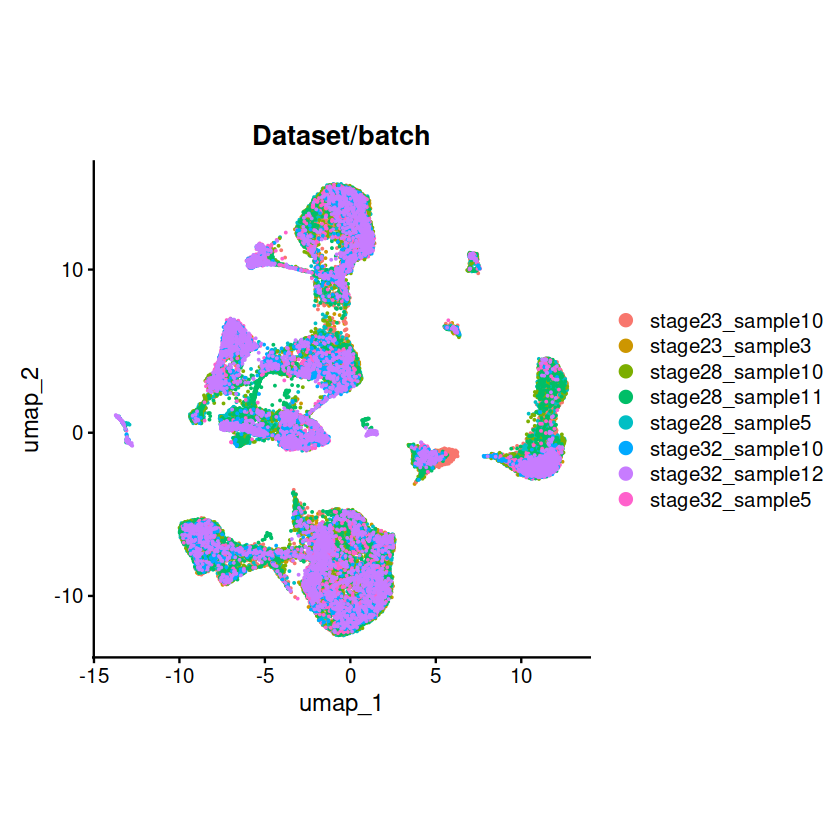

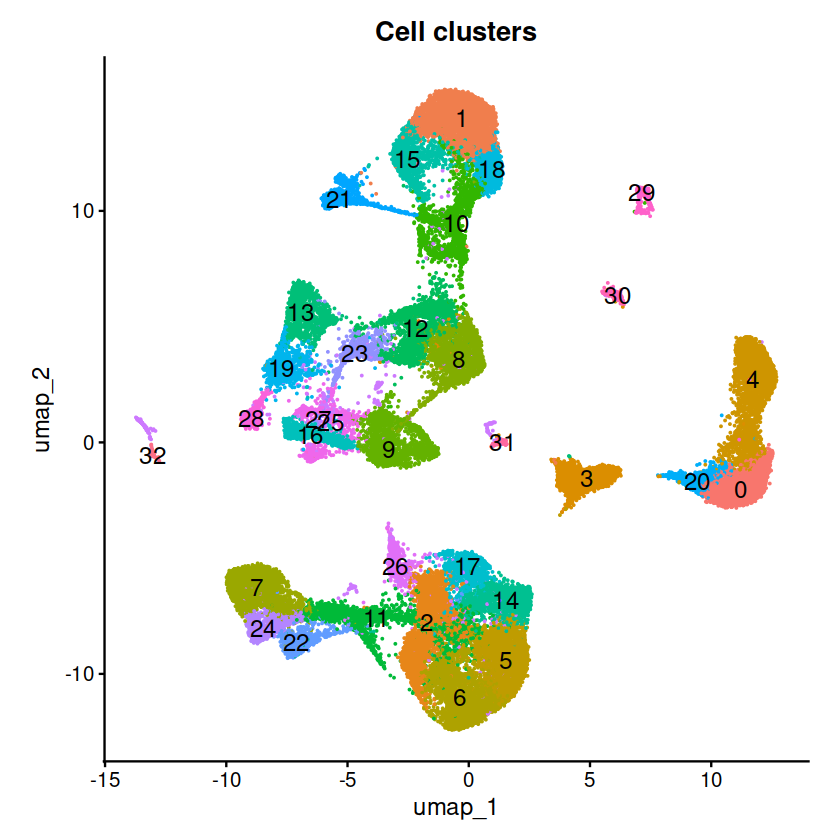

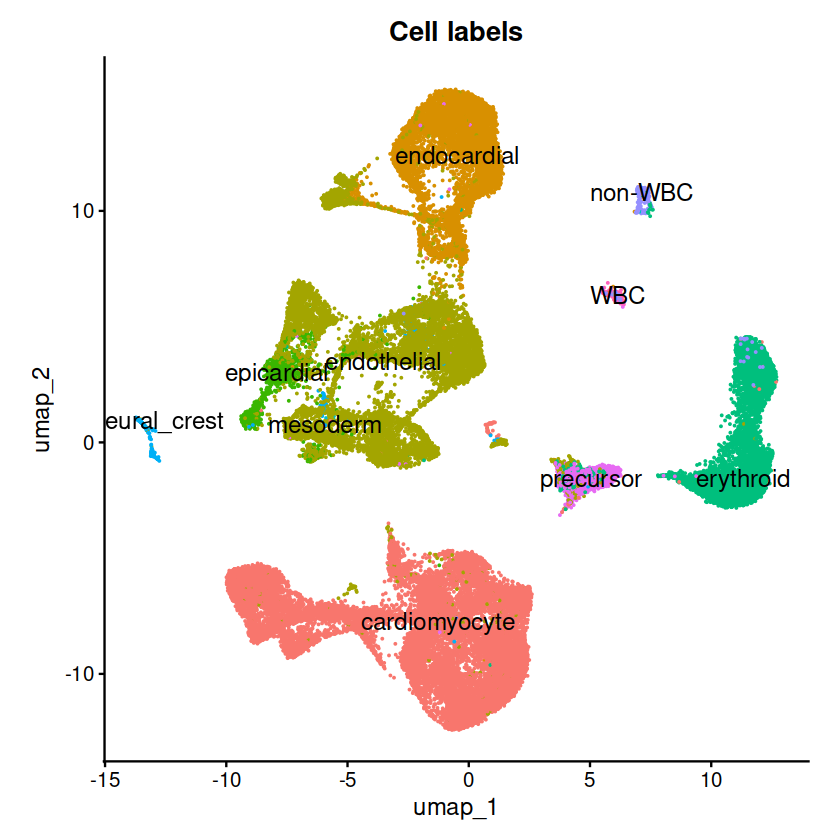

In [27]:
DimPlot(object.ss, group.by = meta.batch) + theme(aspect.ratio = 1) + ggtitle("Dataset/batch")
DimPlot(object.ss, group.by = 'seurat_clusters', label=T, label.size = 5) + NoLegend() + 
theme(aspect.ratio = 1) + ggtitle("Cell clusters")
DimPlot(object.ss, group.by = meta.label, label=T, label.size = 5) + NoLegend() +
theme(aspect.ratio = 1) + ggtitle("Cell labels")

In [28]:
object.ss$old_clusters = mtd1$old_clusters
object.ss

An object of class Seurat 
19007 features across 50547 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 2 layers present: data, scale.data
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

In [15]:
# save
saveRDS(object.ss, file = 'chicken_integrated_ssSTACAS_v2.rds')

In [30]:
df = object.ss@reductions$pca@cell.embeddings
rownames(df) = NULL
colnames(df) = NULL
df[1:2,]

[,1]      [,2]      [,3]       [,4]     [,5]       [,6]       [,7]     
[1,]  15.91102 0.8746136 -13.216874 9.036362 -3.3410421 0.03745443 3.2138221
[2,] -10.28011 4.8751153  -1.781622 7.226099 -0.8512036 2.72134162 0.9589563
     [,8]       [,9]     [,10]    [,11] [,12]     [,13]      [,14]     
[1,] -0.1111932 1.471807 1.593362 ⋯     0.9335278 -0.5242018 -2.3334268
[2,]  3.5310738 2.347402 1.394745 ⋯     1.3027423  2.7501070 -0.8690983
     [,15]       [,16]    [,17]     [,18]      [,19]      [,20]     [,21]    
[1,] -0.57316362 1.211191 0.9154017 -0.9970608 -0.8838181 0.5302498 -1.882584
[2,]  0.09909048 1.302010 1.2089995  0.6370861  2.4217000 2.9004016 -0.691740

In [31]:
# save umap embeddings for integrated dataset
write.table(df, file = 'chicken_ssSTACAS_embeddings_new2.csv', sep = ',',
           row.names = F, col.names = F, quote = F)